In [ ]:
# The expression for the THG depends on the electron scattering rate.
# The scattering rate is given by a sum of a term proportional to the Fermi energy
# and a term proportional to the inverse of the Fermi energy.
# Verify the dependence of the THG on the two proportionality coefficients.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp

In [2]:
from models.cooling_phonons_v3 import CoolingPhonons
from models.graphene_optics import GrapheneTHG
import models.graphene_thermodynamics_v2 as gt

In [3]:
params = {
    "pr_fluenceSI": 110.0,
    "pr_dt": 150.0,
    "pr_eph": 0.320,
    "nsub": 1.4,
    "ntop": 1.4,
    "eF": 0.200,
    "tempK": 30.0,
    "dnE": 0.01,
}
# Convert fluence SI [uJ/cm^-2] to [eV / nm^2].
params["pr_fluence"] = params["pr_fluenceSI"] * 0.062
# Calculate power density [eV / fs nm^2].
params["pr_powdens"] = params["pr_fluence"] / params["pr_dt"]
# Calculate electron density [nm^-2].
dens = gt.twobands_dens_ef_func(params["eF"])
# Calculate the chemical potentials.
muC, muV = gt.photoexc_mu_func(dens, params["dnE"], params["tempK"])
params["muC"] = muC
params["muV"] = muV

In [ ]:
# Create save folder.
run_label = "gamma_coeff"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/06/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

In [39]:
# Set save folder.
saveDir = "./data/06/2023-08-07-22-41-02_gamma_coeff"

In [25]:
# List of the two coefficients in the expression of Gamma.
coeffPropList = np.logspace(-2.0, 1.0, 31)
coeffInvList = np.logspace(-6.0, -1.0, 21)

In [26]:
# Calculate THG efficiency for all temperatures and Fermi energies.

def oneEta3(p):
    # Prepare the object to calculate the THG efficiency.
    thg = GrapheneTHG(nsub=p["nsub"], ntop=p["ntop"], eph=p["pr_eph"], maldagueMin=0.001, maldagueMax=2.0, maldagueNum=301)
    thg.coeffGamma(p["coeffProp"], p["coeffInv"])
    thg.calculate_eta(powdens=p["pr_powdens"], muC=p["muC"], muV=p["muV"], tempK=p["tempK"])
    return (p["ij"][0], p["ij"][1], thg.p["eta"]) 

# Create a list of parameters for the function.
p3_list = []
for iProp,coeffProp in enumerate(coeffPropList):
    for iInv,coeffInv in enumerate(coeffInvList):
        p3_list.append({"coeffProp": coeffProp, "coeffInv": coeffInv, "ij": (iProp,iInv), **params})

In [27]:
with mp.Pool(24) as p:
    thg3_list = p.map(oneEta3, p3_list)

In [28]:
thg3_df = np.zeros((len(coeffPropList),len(coeffInvList)))
for x in thg3_list:
    thg3_df[x[0],x[1]] = x[2]

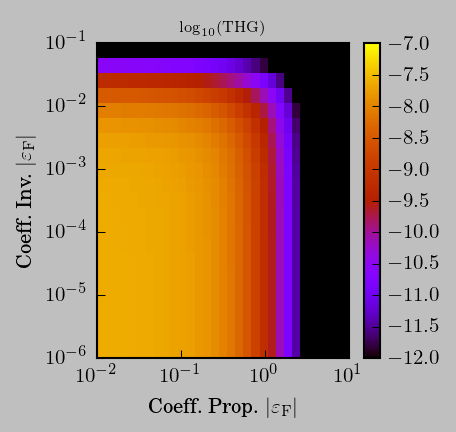

In [40]:
mpl.style.use(["classic", "latex"])
fig = plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
ax1 = plt.axes([0.2, 0.2, 0.6, 0.7])
eta = ax1.imshow(np.log10(thg3_df[:,:].transpose()), origin="lower", aspect="auto", interpolation="none",
                 extent=(np.log10(coeffPropList[0]),np.log10(coeffPropList[-1]),np.log10(coeffInvList[0]),np.log10(coeffInvList[-1])),
                 vmin=-12, vmax=-7, cmap="gnuplot")
tk = [-2, -1, 0, 1]
plt.xticks(tk, [r"$10^{%d}$" % t for t in tk])
tk = [-6, -5, -4, -3, -2, -1]
plt.yticks(tk, [r"$10^{%d}$" % t for t in tk])
plt.xlabel(r"Coeff.~Prop.~$|\varepsilon_{\rm F}|$")
plt.ylabel(r"Coeff.~Inv.~$|\varepsilon_{\rm F}|$")
plt.title(r"\scriptsize $\log_{10}({\rm THG})$")
fig.colorbar(eta)
fig.savefig("%s/eta_vs_coeff_gamma.png" % saveDir, dpi=300);